In [114]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
!ls /dfs/scratch0/nicchiou/MIDRC/meta_info/

cr_Age_dist.png		  MIDRC_table_IL_test.csv   MIDRC_table_NC_test.csv
cr_States_dist.png	  MIDRC_table_IL_train.csv  MIDRC_table_NC_train.csv
MIDRC_table_CA_test.csv   MIDRC_table_IN_test.csv   MIDRC_table_TX_test.csv
MIDRC_table_CA_train.csv  MIDRC_table_IN_train.csv  MIDRC_table_TX_train.csv


In [133]:
root_dir = '/dfs/scratch0/nicchiou/MIDRC/'

# Extract metadata

## Re-define file path

In [134]:
df = pd.read_csv(os.path.join(root_dir, 'meta_info', 'MIDRC_table_CA_train.csv'))
df.head()

,file_path,race,covid19_positive,sex,age,state
0,/dfs/scratch0/nicchiou/MIDRC/data_subset/cr/cl...,White,No,Male,60,CA
1,/dfs/scratch0/nicchiou/MIDRC/data_subset/cr/cl...,White,Yes,Male,49,CA
2,/dfs/scratch0/nicchiou/MIDRC/data_subset/cr/cl...,Asian,No,Male,75,CA
3,/dfs/scratch0/nicchiou/MIDRC/data_subset/cr/cl...,Black or African American,No,Male,61,CA
4,/dfs/scratch0/nicchiou/MIDRC/data_subset/cr/cl...,Asian,No,Male,75,CA


In [135]:
df.loc[:, 'file_path'] = df.loc[:, 'file_path'].apply(lambda x: os.path.join(root_dir, '/'.join(x.split('/')[5:])))
df.file_path.values[:5]

array(['/dfs/scratch0/nicchiou/MIDRC/data_subset/cr/clean_states/1.2.826.0.1.3680043.10.474.419639.313447297747755998855250428772.jpeg',
       '/dfs/scratch0/nicchiou/MIDRC/data_subset/cr/clean_states/2.16.840.1.114274.1818.46922722668294700693460078206080330162.jpeg',
       '/dfs/scratch0/nicchiou/MIDRC/data_subset/cr/clean_states/1.2.826.0.1.3680043.10.474.419639.395695755473692260227147143526.jpeg',
       '/dfs/scratch0/nicchiou/MIDRC/data_subset/cr/clean_states/1.2.826.0.1.3680043.10.474.419639.216723391268633869313204260931.jpeg',
       '/dfs/scratch0/nicchiou/MIDRC/data_subset/cr/clean_states/1.2.826.0.1.3680043.10.474.419639.231691188078318414239621142560.jpeg'],
      dtype=object)

In [137]:
for state in ['CA', 'IL', 'IN', 'NC', 'TX']:
    for split in ['train', 'test']:
        df = pd.read_csv(os.path.join(root_dir, 'meta_info', 'MIDRC_table_{}_{}.csv'.format(state, split)))
        if 'nicchiou' in df.loc[0, 'file_path']:
            continue
        else:
            df.loc[:, 'file_path'] = df.loc[:, 'file_path'].apply(lambda x: os.path.join(root_dir, '/'.join(x.split('/')[5:])))
            df.to_csv(os.path.join(root_dir, 'meta_info', 'MIDRC_table_{}_{}.csv'.format(state, split), index=False))

In [138]:
df = pd.read_csv(os.path.join(root_dir, 'meta_info', 'MIDRC_table_CA_train.csv'))
df.head()

,file_path,race,covid19_positive,sex,age,state
0,/dfs/scratch0/nicchiou/MIDRC/data_subset/cr/cl...,White,No,Male,60,CA
1,/dfs/scratch0/nicchiou/MIDRC/data_subset/cr/cl...,White,Yes,Male,49,CA
2,/dfs/scratch0/nicchiou/MIDRC/data_subset/cr/cl...,Asian,No,Male,75,CA
3,/dfs/scratch0/nicchiou/MIDRC/data_subset/cr/cl...,Black or African American,No,Male,61,CA
4,/dfs/scratch0/nicchiou/MIDRC/data_subset/cr/cl...,Asian,No,Male,75,CA


## Train/Valid/Test stratified split

In [139]:
sample_count = {}

for state in ['CA', 'IL', 'IN', 'NC', 'TX']:
    for split in ['train', 'test']:
        df = pd.read_csv(os.path.join(root_dir, 'meta_info', 'MIDRC_table_{}_{}.csv'.format(state, split)))
        df.loc[:, 'covid19_positive'] = (df['covid19_positive'] == 'Yes').astype(int)
        sample_count['{}_{}'.format(state, split)] = (np.bincount(df.covid19_positive.values) / len(df)).tolist()

In [140]:
sample_count

{'CA_train': [0.7152466367713004, 0.28475336322869954],
 'CA_test': [0.6756756756756757, 0.32432432432432434],
 'IL_train': [0.37884748900717424, 0.6211525109928258],
 'IL_test': [0.3709876543209877, 0.6290123456790123],
 'IN_train': [0.37861915367483295, 0.621380846325167],
 'IN_test': [0.2882882882882883, 0.7117117117117117],
 'NC_train': [0.46267652992602554, 0.5373234700739744],
 'NC_test': [0.46567967698519513, 0.5343203230148048],
 'TX_train': [0.8354114713216958, 0.16458852867830423],
 'TX_test': [0.76, 0.24]}

In [141]:
state_dict = {}

for state in ['CA', 'IL', 'IN', 'NC', 'TX']:
    train_df = pd.read_csv(os.path.join(root_dir, 'meta_info', 'MIDRC_table_{}_train.csv'.format(state)))
    test_df = pd.read_csv(os.path.join(root_dir, 'meta_info', 'MIDRC_table_{}_test.csv'.format(state)))
    df = pd.concat([train_df, test_df], axis=0)
    # Bin age for easier sampling
    bins=[0, 40, 50, 60, 70, 80, 90]
    df['binned_age'] = pd.cut(df['age'], bins=bins, labels=bins[:-1])
    state_dict[state] = df

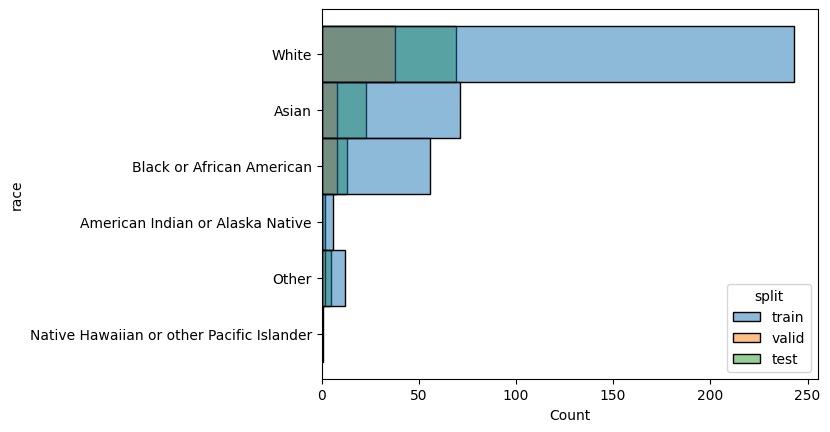

In [144]:
df_learn, df_test = train_test_split(state_dict['CA'], test_size=0.2,
                                     stratify=state_dict['CA'][['covid19_positive', 'sex', 'binned_age']],
                                     random_state=42)
df_train, df_valid = train_test_split(df_learn, test_size=0.1 * len(state_dict['CA']) / len(df_learn),
                                      stratify=df_learn[['covid19_positive', 'sex', 'binned_age']],
                                      random_state=42)

df_train['split'] = 'train'
df_valid['split'] = 'valid'
df_test['split'] = 'test'
df_split = pd.concat([df_train, df_valid, df_test])
assert len(df_split) == len(state_dict['CA'])

# Check to make sure race distribution is consistent across splits
sns.histplot(df_split, y='race', hue='split');

In [160]:
sample_count = {}

for state in ['CA', 'IL', 'IN', 'NC', 'TX']:
    df_learn, df_test = train_test_split(state_dict[state], test_size=0.2,
                                         stratify=state_dict[state][['covid19_positive', 'sex', 'binned_age']],
                                         random_state=42)
    df_train, df_valid = train_test_split(df_learn, test_size=0.1 * len(state_dict[state]) / len(df_learn),
                                          stratify=df_learn[['covid19_positive', 'sex', 'binned_age']],
                                          random_state=42)

    df_train['split'] = 'train'
    df_valid['split'] = 'valid'
    df_test['split'] = 'test'
    df_split = pd.concat([df_train, df_valid, df_test])
    assert len(df_split) == len(state_dict[state])
    assert np.allclose([len(df_train) / len(df_split),
                        len(df_valid) / len(df_split),
                        len(df_test) / len(df_split)], [0.7, 0.1, 0.2], atol=0.01)
    sample_count[state] = [len(df_train), len(df_valid), len(df_test), len(df_learn), len(df_split)]
    
    df_train.to_csv(os.path.join(root_dir, 'meta_info', 'MIDRC_table_{}_train.csv'.format(state)))
    df_valid.to_csv(os.path.join(root_dir, 'meta_info', 'MIDRC_table_{}_valid.csv'.format(state)))
    df_test.to_csv(os.path.join(root_dir, 'meta_info', 'MIDRC_table_{}_test.csv'.format(state)))

In [161]:
sample_count

{'CA': [389, 56, 112, 445, 557],
 'IL': [11341, 1621, 3241, 12962, 16203],
 'IN': [392, 56, 112, 448, 560],
 'NC': [2601, 372, 744, 2973, 3717],
 'TX': [349, 51, 101, 400, 501]}